In [45]:
from glob import glob
import cv2
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation, RotationSpline
import open3d as o3d
import numpy as np

In [62]:
camera_2_img_list = sorted(glob('/media/kbuyukburc/DATASET/KITTI_Visual Odometry Dataset/data_odometry_color/image_2/*'))
lidar_bin_list = sorted(glob('/media/kbuyukburc/DATASET/KITTI_Visual Odometry Dataset/data_odometry_velodyne/00/velodyne/*'))
intrinsic = np.array([[718.856 ,   0.    , 607.1928],
    [  0.    , 718.856 , 185.2157],
    [  0.    ,   0.    ,   1.    ]])
distortion = np.array([0,0,0,0,0.])
zero_vec = np.array([0.,0.,0.])
r_vec = np.array([1.208758, -1.217978,  1.19949])
t_vec = np.array([0.051147, -0.05404 , -0.292197])
ext = np.eye(4)
ext[:3, :3] = Rotation.from_rotvec(r_vec[:3]).as_matrix()    
ext[:3, 3] = t_vec[:3]

In [63]:
def bin_load(bin_file):
    pcd_data = np.fromfile(bin_file, dtype=np.float32).reshape(-1, 4)
    pcd = o3d.geometry.PointCloud() 
    pcd.points = o3d.utility.Vector3dVector(pcd_data[:, :3])
    pcd.colors =  o3d.utility.Vector3dVector(pcd_data[:, 3, None].repeat(3, axis=1))
    return pcd

In [64]:
pcd = bin_load(lidar_bin_list[0])
o3d.visualization.draw_geometries([pcd])

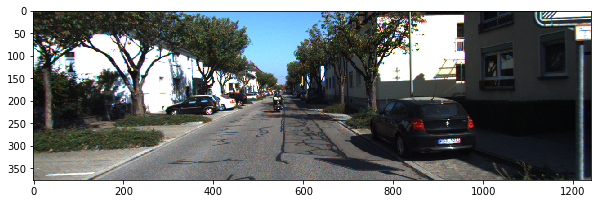

In [65]:
img = cv2.imread(camera_2_img_list[0])
plt.figure(figsize=[10, 10])
plt.imshow(img[..., ::-1])

In [82]:
pcd = bin_load(lidar_bin_list[0])
pcd.transform(ext)
world_points = np.asarray(pcd.points)
world_intensity = np.asarray(pcd.colors)[:, 0]
reproj_lid_pts, joc = cv2.projectPoints(world_points, zero_vec, zero_vec, intrinsic, distortion)
reproj_lid_pts = reproj_lid_pts[:, 0]
reproj_lid_pts_flag = (reproj_lid_pts[:,0] > 0) & (reproj_lid_pts[:,1] > 0) & \
(reproj_lid_pts[:,1] < img.shape[0]-1) & (reproj_lid_pts[:,0] < img.shape[1]-1)  & (world_points[:, 2] > 0)
reproj_points = world_points[reproj_lid_pts_flag]
sortid = np.argsort(np.linalg.norm(reproj_points, axis=1))[::-1]
reproj_points = reproj_points[sortid]
reproj_img_pts = np.rint(reproj_lid_pts[reproj_lid_pts_flag][sortid]).astype(int)
reproj_intensity = world_intensity[reproj_lid_pts_flag][sortid]
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_lidar = img_gray.copy()#.np.ones_like(img_gray) * -1
img_lidar[reproj_img_pts[:,1], reproj_img_pts[:,0]] = reproj_intensity * 255
img_lidar_mask = img_lidar != -1
lidar_hist_data = img_lidar[img_lidar_mask]
img_hist_data = img_gray[img_lidar_mask]

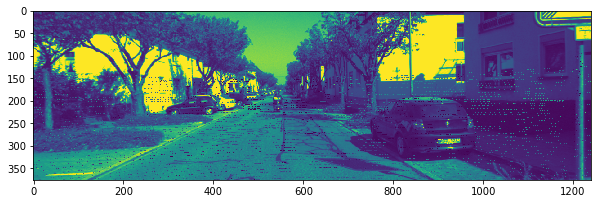

In [84]:
plt.figure(figsize=[10,10])
plt.imshow(img_lidar)

In [68]:
reproj_img_pts

array([[ 453,  177],
       [ 464,  159],
       [ 622,  153],
       ...,
       [1213,  125],
       [1217,  124],
       [1219,  124]])

In [85]:
import torch
from torchvision import models
import numpy as np
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image

In [109]:
import torch.nn as nn
class CalibResnet(nn.Module):
    def __init__(self, in_channels = 1, num_layer = 3):
        super().__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.model = models.resnet18(weights=weights)
        self.num_layer = num_layer
        self.model.conv1 = nn.Conv2d(in_channels = in_channels, 
            out_channels = self.model.conv1.out_channels,
            kernel_size = self.model.conv1.kernel_size,
            stride = self.model.conv1.stride,
            padding = self.model.conv1.padding,
            bias = self.model.conv1.bias
            )

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        if self.num_layer >= 1:
            x = self.model.layer1(x)
        if self.num_layer >= 2:
            x = self.model.layer2(x)
        if self.num_layer >= 3:
            x = self.model.layer3(x)
        if self.num_layer >= 4:
            x = self.model.layer4(x)
        return x
        # x = self.model.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.model.fc(x)

class CalibNet(nn.Module):
    def __init__(self):
        super(self).__init__()
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.camera_model = models.resnet18(weights=weights)
        self.camera_model = models.resnet18(weights=weights)

In [111]:
transform=transforms.Compose([transforms.Resize(256), transforms.ToTensor()])
CalibResnet(in_channels=3)(transform(Image.open(camera_2_img_list[0])).unsqueeze(0)).shape

torch.Size([1, 256, 16, 53])

In [113]:
transform=transforms.Compose([transforms.ToTensor()])
CalibResnet(in_channels=1)(transform(img_lidar).unsqueeze(0)).shape

torch.Size([1, 256, 24, 78])

In [90]:
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

In [92]:
model(transform(Image.open(camera_2_img_list[0])).unsqueeze(0)).shape

torch.Size([1, 1000])

In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
ret = model.conv1(transform(Image.open(camera_2_img_list[0])).unsqueeze(0))
ret = model.bn1(ret)
ret = model.relu(ret)
ret = model.maxpool(ret)
ret = model.layer1(ret)
ret = model.layer2(ret)
ret = model.layer3(ret)
ret = model.layer4(ret)
ret = model.avgpool(ret)
ret = torch.flatten(ret, 1)
ret = model.fc(ret)

In [27]:
ret.shape

torch.Size([1, 1000])